<img src = "https://imgur.com/HE0kDhA.jpg"  align = "center">

# **Transfer Learning**

Di modul-modul sebelumnya, kita sudah belajar bagaimana cara membuat arsitektur CNN dari awal (*from scratch*). Membuat arsitektur sendiri memang lebih fleksibel. Kita dapat menambah dan mengurangi layer semau kita. Akan tetapi, membuat arsitektur sendiri kadangkala juga merepotkan. Karena kita harus mengatur (melakukan tuning) terhadap begitu banyak parameter. Ada cara yang lebih baik dalam membuat model deep learning menggunakan metode CNN, yakni dengan memanfaatkan model yang telah dibuat oleh peneliti sebelumnya. Model-model ini terbukti mampu menghasilkan nilai akurasi dan nilai error yang baik, serta menduduki peringkat atas di beberapa kompetisi. Beberapa model sudah disediakan oleh library Keras, dan kita hanya tinggal menggunakannya. Proses menggunakan kembali model yang sudah ada, untuk dipasang di dataset yang berbeda, dikenal dengan istilah **Transfer Learning**






---



---



# Langkah Praktikum

<h3>Load Dataset</h3>

In [1]:
# Download dataset
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2021-01-19 13:42:38--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.128, 142.250.101.128, 2607:f8b0:4023:c03::80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   246MB/s    in 0.3s    

2021-01-19 13:42:39 (246 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [2]:
# Ekstrak dataset

import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
# Definisikan path untuk data train dan data validation

base_dir = '/tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

Karena model yang nantinya kita gunakan cukup kompleks, maka untuk mempersingkat waktu training, kita akan mengecilkan ukuran image yang ada di dataset menjadi 50 x 50

In [4]:
import cv2
import numpy as np

# Gather data train
train_data = []
train_label = []
for r, d, f in os.walk(train_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            train_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            train_label.append(label)

train_data = np.array(train_data)
train_label = np.array(train_label)

In [5]:
# Gather data validation
val_data = []
val_label = []
for r, d, f in os.walk(validation_dir):
    for file in f:
        if ".jpg" in file:
            imagePath = os.path.join(r, file)
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (50,50))
            val_data.append(image)
            label = imagePath.split(os.path.sep)[-2]
            val_label.append(label)

val_data = np.array(val_data)
val_label = np.array(val_label)

<h3>Data Preprocessing</h3>

In [6]:
# Tampilkan shape dari data train dan data validation
print("Train Data = ", train_data.shape)
print("Train Label = ", train_label.shape)
print("Validation Data = ", val_data.shape)
print("Validation Label = ", val_label.shape)

Train Data =  (2000, 50, 50, 3)
Train Label =  (2000,)
Validation Data =  (1000, 50, 50, 3)
Validation Label =  (1000,)


In [7]:
# Normalisasi dataset
print("Data sebelum di-normalisasi ", train_data[0][0][0])

x_train = train_data.astype('float32') / 255.0
x_val = val_data.astype('float32') / 255.0
print("Data setelah di-normalisasi ", x_train[0][0][0])

Data sebelum di-normalisasi  [226 235 238]
Data setelah di-normalisasi  [0.8862745  0.92156863 0.93333334]


In [8]:
# Transformasi label encoder
from sklearn.preprocessing import LabelEncoder

print("Label sebelum di-encoder ", train_label[995:1005])

lb = LabelEncoder()
y_train = lb.fit_transform(train_label)
y_val = lb.fit_transform(val_label)

print("Label setelah di-encoder ", y_train[995:1005])

Label sebelum di-encoder  ['cats' 'cats' 'cats' 'cats' 'cats' 'dogs' 'dogs' 'dogs' 'dogs' 'dogs']
Label setelah di-encoder  [0 0 0 0 0 1 1 1 1 1]


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                        height_shift_range=0.1, shear_range=0.2, 
                        zoom_range=0.8, horizontal_flip=True,
                        fill_mode="nearest")

<h3>Definisikan Model</h3>

Dalam transfer learning, ada beberapa teknik yang bisa digunakan. Diantaranya:
*   *Direct Used* (Langsung menggunakan model dan bobot yang ada)
*   *Network Surgery* (Menggunakan arsitektur dan bobot yang sama untuk Feature Extracted Layer, akan tetapi membuat Fully Connected Layer sendiri, dan melakukan training bobot khusus untuk Fully Connected Layer tersebut)
*   *Learning from Scratch* (Menggunakan arsitektur dari model sebelumnya, tapi tidak menggunakan bobotnya. Sehingga bobot harus ditraining ulang menggunakan dataset kita sendiri)
*   Gabungan dari ketiganya

Pada praktikum kali ini, kita akan mencoba menggunakan teknik *Network Surgery*. Dimana kita akan menggunakan Feature Extracted Layer dari model sebelumnya (disini kita akan menggunakan "VGG16"), kemudian kita pasangkan dengan Fully Connected Layer yang kita buat sendiri.

In [10]:
# Pertama, kita import dulu library yang dibutuhkan
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Input
from tensorflow.keras.applications.vgg16 import VGG16

In [11]:
# Kita load model VGG16, kemudian kita potong bagian Top atau Fully Connected Layernya
baseModel = VGG16(include_top=False, input_tensor=Input(shape=(50, 50, 3)))

58892288/58889256 [==============================] - 0s 0us/step


In [12]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Bisa dilihat di model.summary() di atas, VGG16 memiliki total 19 layer pada Feature Extraction Layer-nya. Serta memiliki 14,7 juta parameter yang harus ditrain. Akan tetapi, disini kita akan menggunakan bobot default milik VGG16. Bobot ini telah dilatih sebelumnya menggunakan dataset 'imagenet'. Dataset ini berisi kumpulan data image yang jumlahnya jutaan. Sehingga, kita tidak perlu melatihnya kembali.

Berikutnya, kita akan mendefinisikan Fully Conected Layer kita sendiri. Layer ini nantinya akan kita pasangkan dengan Feature Extraction Layer milik VGG16

In [13]:
class FCHeadNet:
  def build(baseModel, classes, D):
    headModel = baseModel.output
    headModel = Flatten(name="flatten")(headModel)
    headModel = Dense(D, activation='elu')(headModel)
    headModel = Dropout(0.5)(headModel)
    headModel = Dense(classes, activation='sigmoid')(headModel)
    return headModel

In [14]:
headModel = FCHeadNet.build(baseModel, 1, 256)
model = Model(inputs=baseModel.input, outputs=headModel)

Agar nantinya model hanya perlu melakukan train pada bobot yang terdapat pada Fully Connected Layer, maka kita perlu membekukan (*Freeze*) Feature Extraction Layer milik VGG16 menggunakan code di bawah

In [16]:
for layer in baseModel.layers:
  layer.trainable = False

In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     

Dalam model.summary() di atas, terlihat bahwa parameter yang *trainable* hanya parameter milik Fully Connected Layer, sedangkan bobot-bobot lain yang merupakan bawaan dari VGG16 tidak ikut dilatih.

Kemudian, kita tinggal mengcompile dan melatih model tersebut

In [18]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=1e-3), 
              loss='binary_crossentropy', 
              metrics=['acc'])

In [19]:
H = model.fit_generator(aug.flow(x_train, y_train, batch_size=20),
                        validation_data=(x_val, y_val), epochs=15)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/15
100/100 [==============================] - 47s 457ms/step - loss: 0.7461 - acc: 0.5724 - val_loss: 0.5955 - val_acc: 0.6780
Epoch 2/15
100/100 [==============================] - 45s 449ms/step - loss: 0.6947 - acc: 0.6096 - val_loss: 0.6422 - val_acc: 0.6380
Epoch 3/15
100/100 [==============================] - 45s 452ms/step - loss: 0.6462 - acc: 0.6491 - val_loss: 0.6050 - val_acc: 0.6660
Epoch 4/15
100/100 [==============================] - 45s 449ms/step - loss: 0.6397 - acc: 0.6337 - val_loss: 0.5335 - val_acc: 0.7400
Epoch 5/15
100/100 [==============================] - 45s 451ms/step - loss: 0.6257 - acc: 0.6342 - val_loss: 0.5857 - val_acc: 0.6840
Epoch 6/15
100/100 [==============================] - 45s 449ms/step - loss: 0.6204 - acc: 0.6625 - val_loss: 0.5360 - val_acc: 0.7260
Epoch 7/15
100/100 [==============================] - 45s 449ms/step - loss: 0.6268 - acc: 0.6494 - val_loss: 0.5423 - val_acc: 0.7270
Epoch 8/15
100/100 [==============================] - 4

<h3>Evaluasi Model</h3>

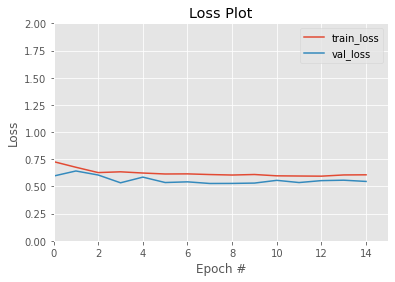

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.axis([0, 15, 0, 2])
plt.plot(np.arange(0, 15), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 15), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

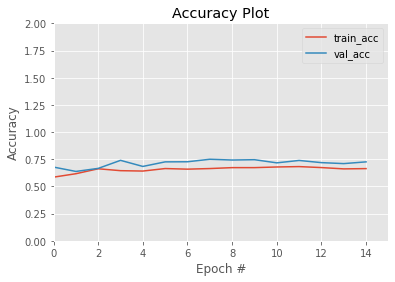

In [21]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.axis([0, 15, 0, 2])
plt.plot(np.arange(0, 15), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 15), H.history["val_acc"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [22]:
from sklearn.metrics import classification_report

pred = model.predict(x_val)
labels = (pred > 0.5).astype(np.int)

print(classification_report(y_val, labels))

              precision    recall  f1-score   support

           0       0.81      0.59      0.68       500
           1       0.68      0.86      0.76       500

    accuracy                           0.73      1000
   macro avg       0.74      0.73      0.72      1000
weighted avg       0.74      0.73      0.72      1000



<h3>Save & Load Model</h3>

Untuk menyimpan model beserta bobot yang sudah kita definisikan sebelumnya, kita cukup mengetikkan code berikut:

In [23]:
# save the network to disk
model.save("modelku.hdf5")

Sementara untuk me-load model yang telah disimpan, bisa dilakukan dengan cara seperti ini:

In [24]:
from tensorflow.keras.models import load_model

my_model = load_model("modelku.hdf5")

In [25]:
my_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 50, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 50, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 25, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 25, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 25, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0     